#E2E Deep Learning Project Task

*  **Network used**: Convolutional Neural Network

*  **Frameworks used:** 
Keras (for Training)
Scikit-learn (for reporting and data splitting)

*  **Environment used:** 
Google Colaboratory
---



Importing libraries

In [0]:
#Dependencies
from __future__ import print_function
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Dropout, Flatten, AveragePooling2D, BatchNormalization, Activation, Input
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras import backend as K
import tensorflow as tf
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Using TensorFlow backend.


*Note: Tensorflow version 1.15.0 was used as a backend for keras*



In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount= False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Setting the paths for the data to be retrieved.

*You can change the variable "pth" according to your data path*

In [0]:
pth= '/content/drive/My Drive/'   #enter your path here

#Load dataset
photon_data  = h5py.File(pth+  'SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5')
photon_X  = np.array(photon_data['X'])
photon_Y  = np.array(photon_data['y'])

electron_data= h5py.File(pth+ 'SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5')
electron_X= np.array(electron_data['X'])
electron_Y= np.array(electron_data['y'])

X_train= np.concatenate((photon_X, electron_X))
y_train= np.concatenate((photon_Y, electron_Y))

###Data Visualization

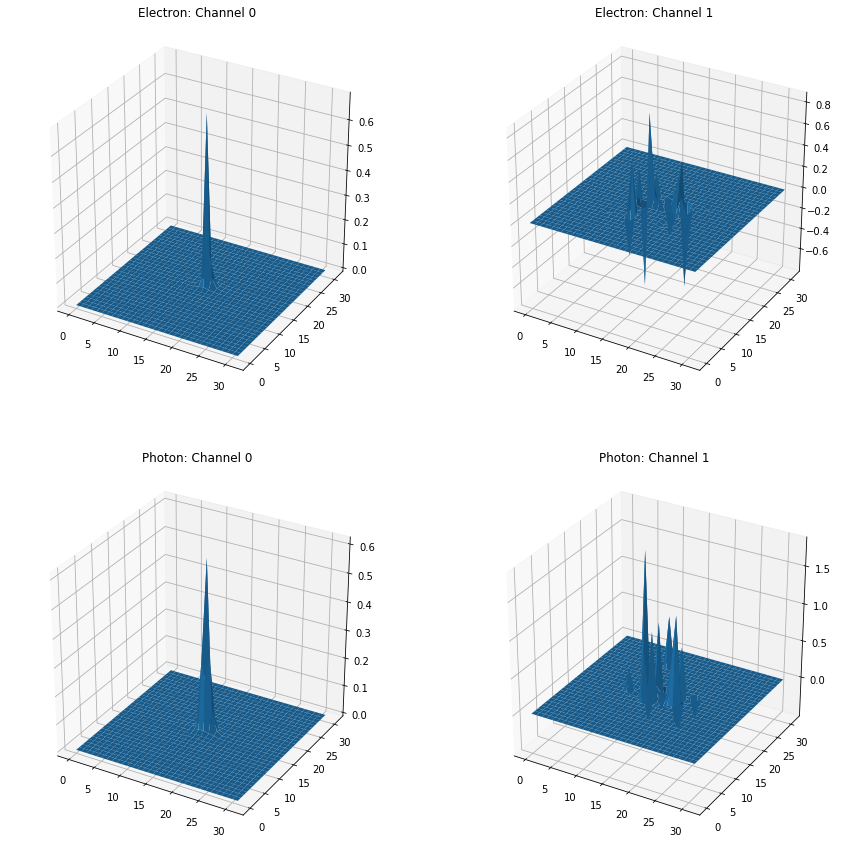

In [0]:
x = range(32)
y = range(32)

e1= electron_X[1,:,:,0]
e2= electron_X[1,:,:,1]
p1= photon_X[1,:,:,0]
p2= photon_X[1,:,:,1]

hf = plt.figure(figsize = (15,15))
ha = hf.add_subplot(221, projection='3d')
hb = hf.add_subplot(222, projection='3d')
hc = hf.add_subplot(223, projection='3d')
hd = hf.add_subplot(224, projection='3d')

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X, Y, e1)
ha.title.set_text('Electron: Channel 0')
hb.plot_surface(X, Y, e2)
hb.title.set_text('Electron: Channel 1')
hc.plot_surface(X, Y, p1)
hc.title.set_text('Photon: Channel 0')
hd.plot_surface(X, Y, p2)
hd.title.set_text('Photon: Channel 1')

plt.show()

###Data Preprocessing

I calculated the mean and standarard deviation for the data. It came out to be:

Input Channel # |  Mean | Standard Deviation
---|---|---
0 | 4.3932467e-09 |  0.99999964
1|-1.0493275e-08|  0.9999994

Mean was very close to 0 while the standard deviation was very close to 1. Thus, I did not normalize.

Split the data into the following parts

Type                 | Variable Name | Percentage
--- | --- | ---
Train Set            | X_train       | 60%
Cross Validation Set | X_val         | 20%
Test Set             | X_test        | 20%





---
*I created a smaller dataset portion X_train1 and trained the model on it for several epochs so that the weights have a better initialization as compared to when trained on the entire dataset*

In [0]:
#shuffle and train-val-test split
X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size= 0.4)
X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, test_size= 0.5)

In [0]:
X_train1, X_train2, y_train1, y_train2= train_test_split(X_train, y_train, train_size = 0.4)

##Neural Network

I tried the following approaches:

*   Network with only fully connected layers
*   Network with 1D convolutions
*   Convolutional Neural Network with hinge loss
*   Convolutional Neural Network with binary cross-entropy loss

###Experimenting with New Features

CNN with binary cross-entropy loss works best with this dataset
I tried new features like:
 

*   dividing hit energy by hit time
*   using square of energy 
but the best results were with a simple CNN on the data



In [0]:
#hyperparameters
batch_size = 2048   #yeh acha hayb isko na cherna
num_classes = 2
epochs = 50


activation= 'relu'


# Neural network
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3),
                 activation=activation,
                 input_shape=(32,32,2), padding= 'same'))
model.add(Conv2D(16, (3, 3), activation=activation,padding= 'same'))
model.add(AveragePooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))
model.add(Conv2D(32, (3, 3), activation=activation,padding= 'same'))
model.add(Conv2D(48, (3, 3), activation=activation,padding= 'same'))
model.add(AveragePooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))
model.add(Conv2D(54, (3, 3), activation=activation,padding= 'same'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation=activation,padding= 'same'))
#model.add(Dropout(0.2))
model.add(AveragePooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))
model.add(Flatten())
model.add(Dense(1024))
model.add(Dropout(0.2))
model.add(Dense(1024))
#model.add(BatchNormalization())
model.add(Activation(activation=activation))
model.add(Dense(512))
#model.add(BatchNormalization())
model.add(Activation(activation=activation))
model.add(Dense(64))
#model.add(BatchNormalization())
model.add(Activation(activation=activation))
model.add(Dense(1,activation='sigmoid'))  #yeh sigmmoid tou na hilao na
optimizer = keras.optimizers.Adam(lr = 0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train1, y_train1,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 119520 samples, validate on 99600 samples
Epoch 1/50





119520/119520 [==============================] - 28s 236us/step - loss: 0.6930 - acc: 0.5008 - val_loss: 0.6915 - val_acc: 0.5278
Epoch 2/50
119520/119520 [==============================] - 13s 106us/step - loss: 0.6849 - acc: 0.5536 - val_loss: 0.6808 - val_acc: 0.5680
Epoch 3/50
119520/119520 [==============================] - 13s 105us/step - loss: 0.6738 - acc: 0.5831 - val_loss: 0.6594 - val_acc: 0.6054
Epoch 4/50
119520/119520 [==============================] - 13s 105us/step - loss: 0.6597 - acc: 0.6069 - val_loss: 0.6530 - val_acc: 0.6135
Epoch 5/50
119520/119520 [==============================] - 13s 105us/step - loss: 0.6543 - acc: 0.6140 - val_loss: 0.6516 - val_acc: 0.6178
Epoch 6/50
119520/11

In [0]:
#Multiply learing rate by 0.7 if the performance on validation set does not improve for 5 epochs 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=5, min_lr=0.000001)


model.fit(X_train, y_train,
          batch_size=5000,
          epochs=100,
          verbose=1,
          validation_data=(X_val, y_val),callbacks=[reduce_lr])
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 298800 samples, validate on 99600 samples
Epoch 1/100
298800/298800 [==============================] - 26s 88us/step - loss: 0.5432 - acc: 0.7318 - val_loss: 0.5511 - val_acc: 0.7249
Epoch 2/100
298800/298800 [==============================] - 26s 87us/step - loss: 0.5431 - acc: 0.7316 - val_loss: 0.5468 - val_acc: 0.7289
Epoch 3/100
298800/298800 [==============================] - 26s 87us/step - loss: 0.5426 - acc: 0.7326 - val_loss: 0.5472 - val_acc: 0.7285
Epoch 4/100
298800/298800 [==============================] - 26s 87us/step - loss: 0.5426 - acc: 0.7320 - val_loss: 0.5510 - val_acc: 0.7255
Epoch 5/100
298800/298800 [==============================] - 26s 87us/step - loss: 0.5430 - acc: 0.7317 - val_loss: 0.5474 - val_acc: 0.7283
Epoch 6/100
298800/298800 [==============================] - 26s 87us/step - loss: 0.5428 - acc: 0.7324 - val_loss: 0.5458 - val_acc: 0.7299
Epoch 7/100
298800/298800 [==============================] - 26s 87us/step - loss: 0.5420 - acc: 0.7330

####Confusion Matrix

In [0]:
y_pred = model.predict_classes(X_test)
c_matrix = confusion_matrix(y_test.tolist(), y_pred.tolist())

# making a dataframe of confusion matrix for better visualization
c_matrix_df = pd.DataFrame({'True Photon': c_matrix[:, 0], 'True Electron': c_matrix[:, 1], 'Conf_Mat':['Pred Photon', 'Pred Electron']}).set_index('Conf_Mat')
c_matrix_df

,True Photon,True Electron
Conf_Mat,,
Pred Photon,35451,14270
Pred Electron,12251,37628


####Classification Report

In [0]:
target_names = ['Photon', 'Electron']
print(classification_report(y_test.tolist(), y_pred.tolist(), target_names=target_names))

              precision    recall  f1-score   support

      Photon       0.74      0.71      0.73     49721
    Electron       0.73      0.75      0.74     49879

    accuracy                           0.73     99600
   macro avg       0.73      0.73      0.73     99600
weighted avg       0.73      0.73      0.73     99600



####Saving Model as pb file

Coutesy: https://medium.com/@pipidog/how-to-convert-your-keras-models-to-tensorflow-e471400b886a

In [0]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [0]:
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, "/content/drive/My Drive/task_GSoC", "my_model.pb", as_text=False)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 93 variables.
INFO:tensorflow:Converted 93 variables to const ops.


'/content/drive/My Drive/task_GSoC/my_model.pb'